# Introduction to Time Series and Visualization

### General Topics
- Visualization, why bother?
- Levels might not be on the level.
- Trend, Seasonality, Cycles.
- Scatterplots and Autocorrelations.

In [1]:
# load forecasting libraries, suppressing messages to avoid notebook clutter
suppressMessages(library(fable))

suppressMessages(library(forecast))

suppressMessages(library(tidyverse))

suppressMessages(library(tsibble))

suppressMessages(library(scales))

suppressMessages(library(feasts))

The `prepdata` file does a couple of things that you will want to check when importing your data:

- Converts the `DATE` field to a datetime, as it generally is imported as a `string` or `object`.  
- Switches from a `DataFrame` to a `Series`, mainly for our convenience when working with it as a univariate time series.  
- Fixes the data type in the `nasdaq` from an `object` to `numeric`. The data has missing values that are in the raw data represented by a `.` (period).
- Aggregates the daily series to monthly and finds the last observation in the month, leading to the month-end value of the index.

Make sure you check for missing values and do the correct conversion of your time index before starting any analysis.

I won't include an ancillary script each time, but this demonstrates how if you wanted to modularize your code.

In [2]:
source('scripts/w01prepdata.R')

nasdaq100 %>% head(5)

,Jan,Feb,Mar,Apr,May,Jun
1986,132.93,140.43,148.86,154.91,163.16,162.62


## [NASDAQ-100 Index](https://www.nasdaq.com/solutions/nasdaq-100)
NASDAQ OMX Group, NASDAQ 100 Index [NASDAQ100], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/NASDAQ100, August 13, 2023.

Units:  Index, Not Seasonally Adjusted
Frequency:  Daily, Close

The observations for the NASDAQ 100 Index represent the daily index value at market close. The market typically closes at 4 PM ET, except for holidays when it sometimes closes early. We have transformed it to a monthly time-series by converting it to the month-ending price. This is to simplify the analysis, irregular daily observations are more difficult to work with and we'll cover them later.

The NASDAQ 100 Index includes 100 of the largest domestic and international non-financial securities listed on The NASDAQ Stock Market based on market capitalization.

In [3]:
nasdaq100 %>% head(96)

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
1986,132.93,140.43,148.86,154.91,163.16,162.62,144.52,151.70,137.50,144.48,147.94,141.41
1987,166.68,182.75,186.04,184.83,188.77,189.24,196.35,209.57,205.50,150.07,137.13,156.25
1988,159.13,172.64,173.26,175.92,173.34,189.03,181.16,171.00,179.37,174.78,169.19,177.41
1989,186.47,183.79,185.87,200.47,214.54,204.59,214.28,222.00,226.41,222.62,224.44,223.84
1990,201.94,207.91,213.15,205.81,236.15,238.46,223.38,193.62,177.06,172.56,192.66,200.53
1991,232.43,250.12,264.90,263.65,279.00,254.19,272.15,287.40,287.54,292.50,284.79,330.86
1992,338.31,345.88,323.05,307.86,315.30,301.23,310.89,299.26,313.19,329.15,350.96,360.19
1993,370.56,351.14,359.42,339.95,368.11,366.13,352.87,372.65,382.72,390.99,386.76,398.28


## What Can You Saw About the Data?
- Too many data points to internalize.
- Multiple dimensions (trend, seasonality, period-to-period changes)
- May able able to compute simple mental queries, but very limited.

## The Case for Visualizing

- Compact way to show the data.
- Easy to communicate.
- Easy to understand what the data is suggesting.

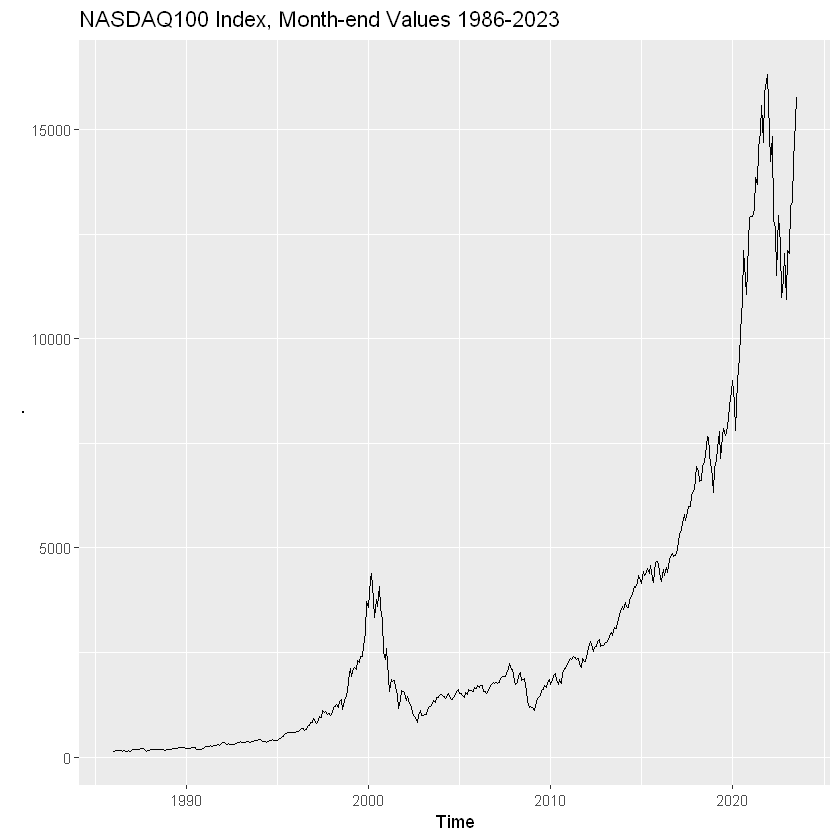

In [4]:
nasdaq100 %>% autoplot() + ggtitle('NASDAQ100 Index, Month-end Values 1986-2023')

### Best Practices
- Self-sufficient principle
- Simple is better
- Labeling
- Avoid chart clutter

### Time Can Be Visually Misleading

- Compound growth over long periods can lead to exponential growth
- Crowds out the ability to internalize growth rates

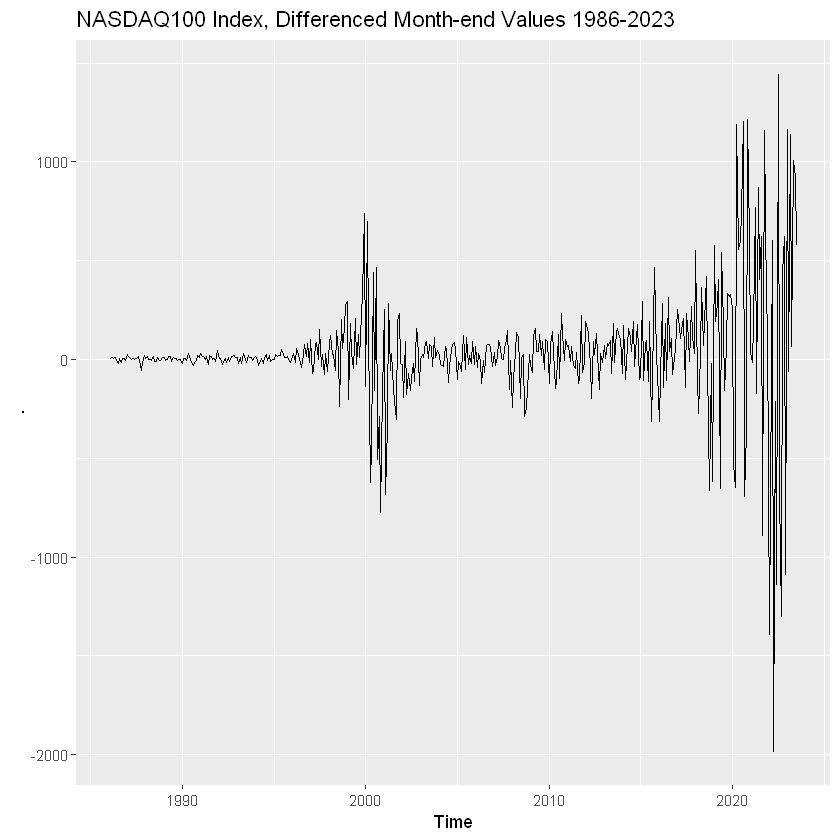

In [5]:
nasdaq100 %>% diff() %>% autoplot() + ggtitle('NASDAQ100 Index, Differenced Month-end Values 1986-2023')

### Does the above look like it would satisfy assumptions in most linear models?

### Log-Transformation

- Using a log-transform for time series data is fairly common
- Simple differences will essentially represent percent changes

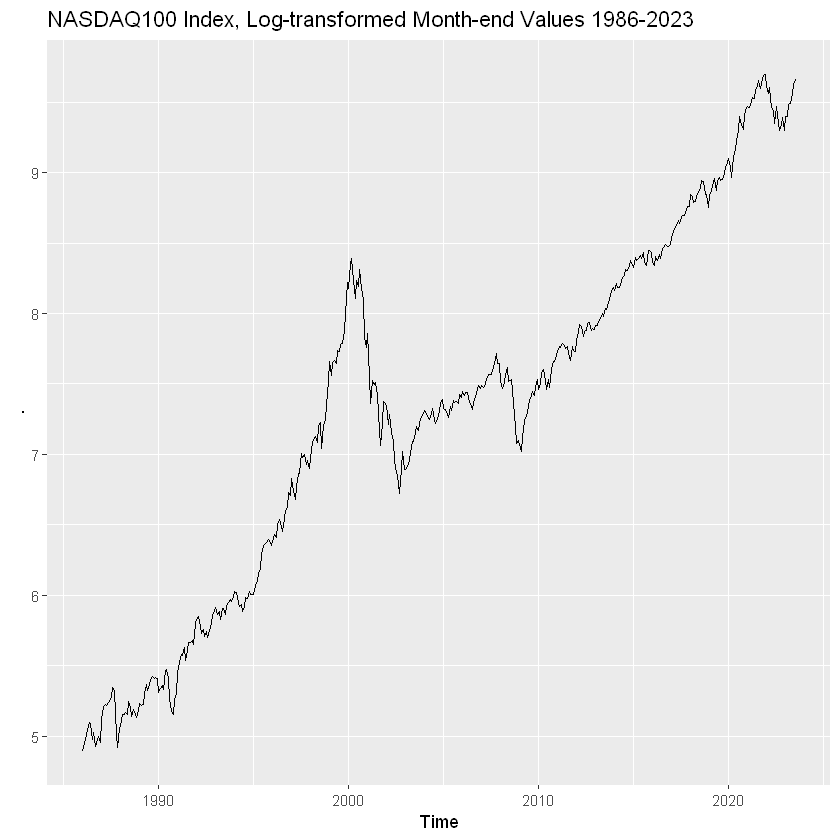

In [6]:
logNasdaq100 <- log(nasdaq100)
logNasdaq100 %>% autoplot() + ggtitle('NASDAQ100 Index, Log-transformed Month-end Values 1986-2023')

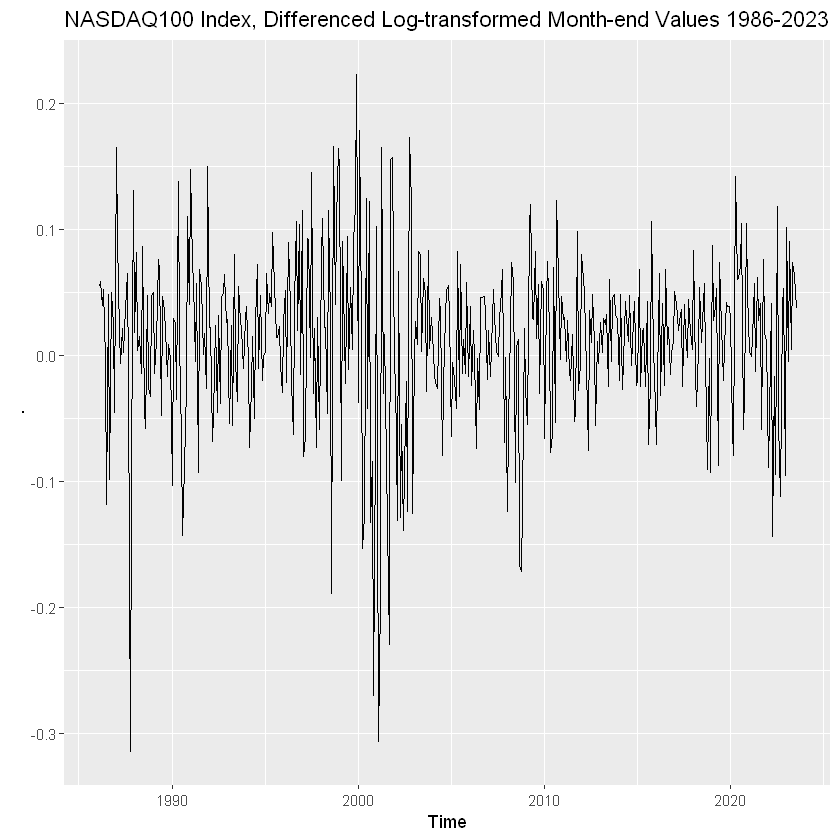

In [7]:
logNasdaq100 %>% diff() %>% autoplot() + 
    ggtitle(ggtitle('NASDAQ100 Index, Differenced Log-transformed Month-end Values 1986-2023'))

Warning message:
"The dot-dot notation (`..count..`) was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(count)` instead."
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


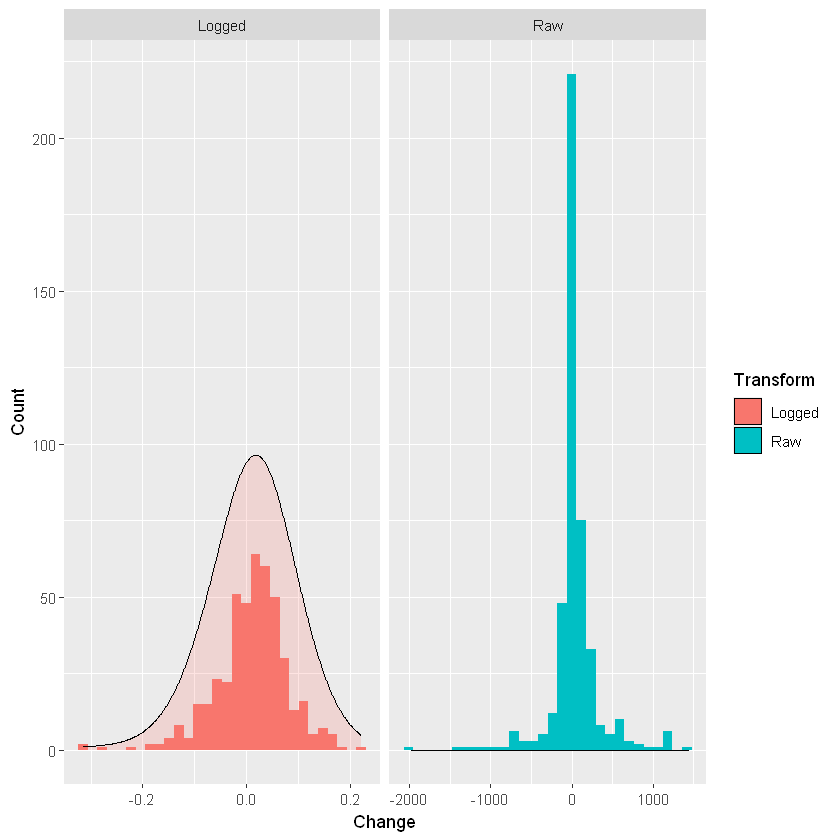

In [8]:
raw <- as.data.frame(nasdaq100 %>% diff() %>% as.vector())
names(raw) <- 'Raw'

lraw <- as.data.frame(logNasdaq100 %>% diff() %>% as.vector())
names(lraw) <- 'Logged'

comb <- bind_cols(raw, lraw) %>% pivot_longer(cols=c('Raw','Logged'), names_to = 'Transform', values_to = 'Change')
comb %>% ggplot(aes(Change, fill=Transform)) + geom_histogram() +
facet_grid(cols=vars(Transform), scales = 'free_x') +
ylab('Count') + geom_density(aes(y=0.045*..count..), colour="black", adjust=4, alpha=.2)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


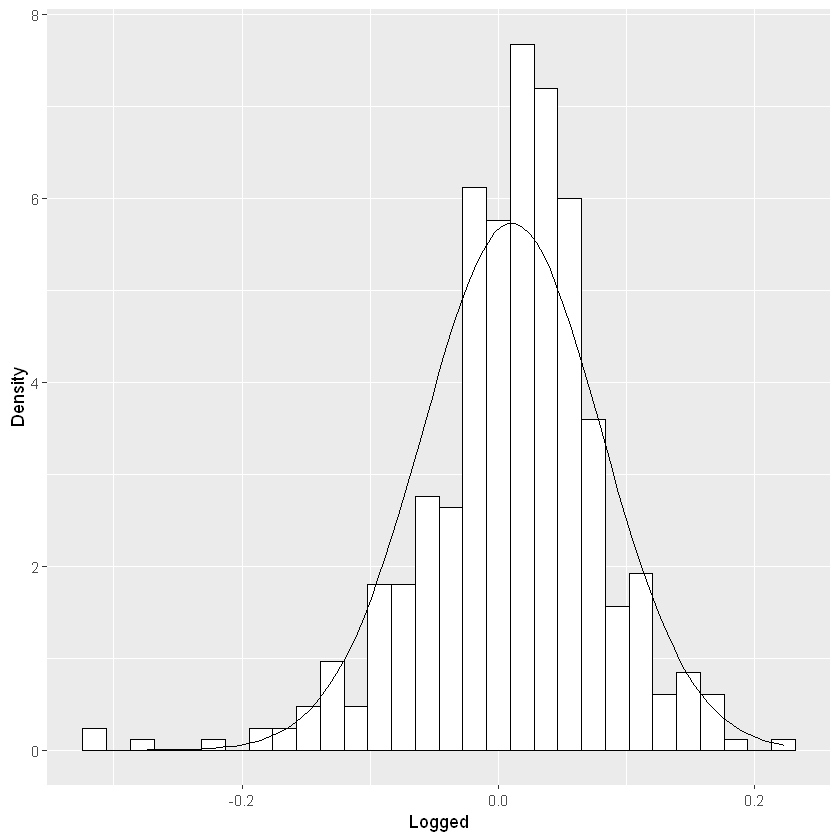

In [9]:
comb <- bind_cols(raw, lraw)
ggplot(comb, aes(x = Logged)) + 
    geom_histogram(aes(y =..density..),
                   colour = "black", 
                   fill = "white") +
stat_function(fun = dnorm, args = list(mean = mean(comb$Logged), sd = sd(comb$Logged))) +
ylab('Density')

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


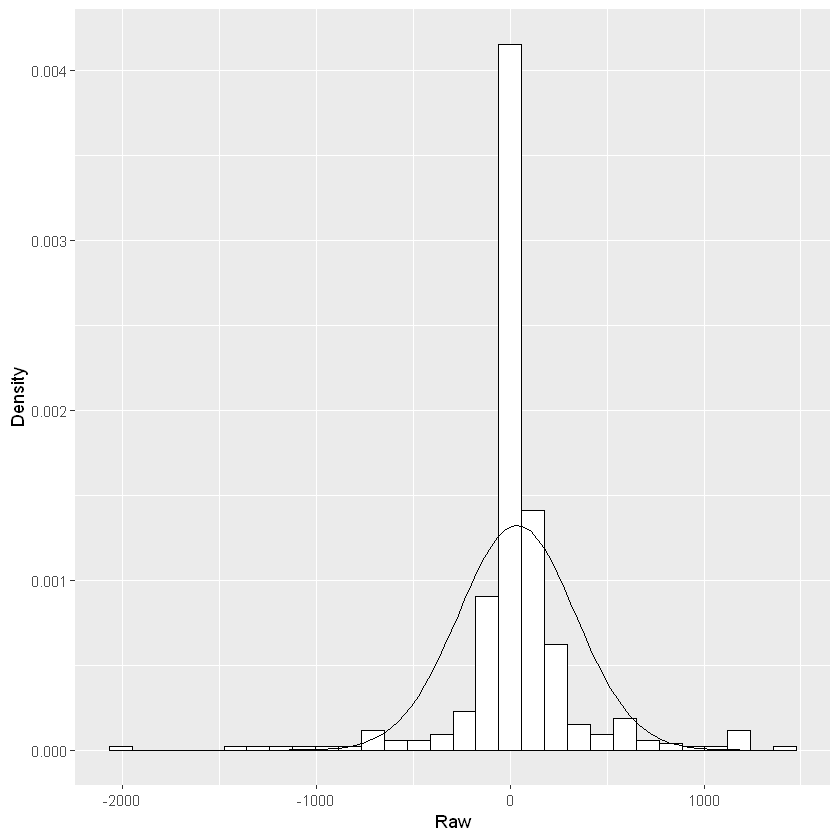

In [10]:
ggplot(comb, aes(x = Raw)) + 
    geom_histogram(aes(y =..density..),
                   colour = "black", 
                   fill = "white") +
stat_function(fun = dnorm, args = list(mean = mean(comb$Raw), sd = sd(comb$Raw))) +
ylab('Density')

### General Characteristics that can Descibe a Time Series
- Trend
- Cycle
- Seasonality
- Noise

### Trend
- Long-term increases or decreases in the time series.
- Might be linear, maybe exponential, describe it by the general shape and general persistence.
- Sometimes there may be several localized trends within a time series.

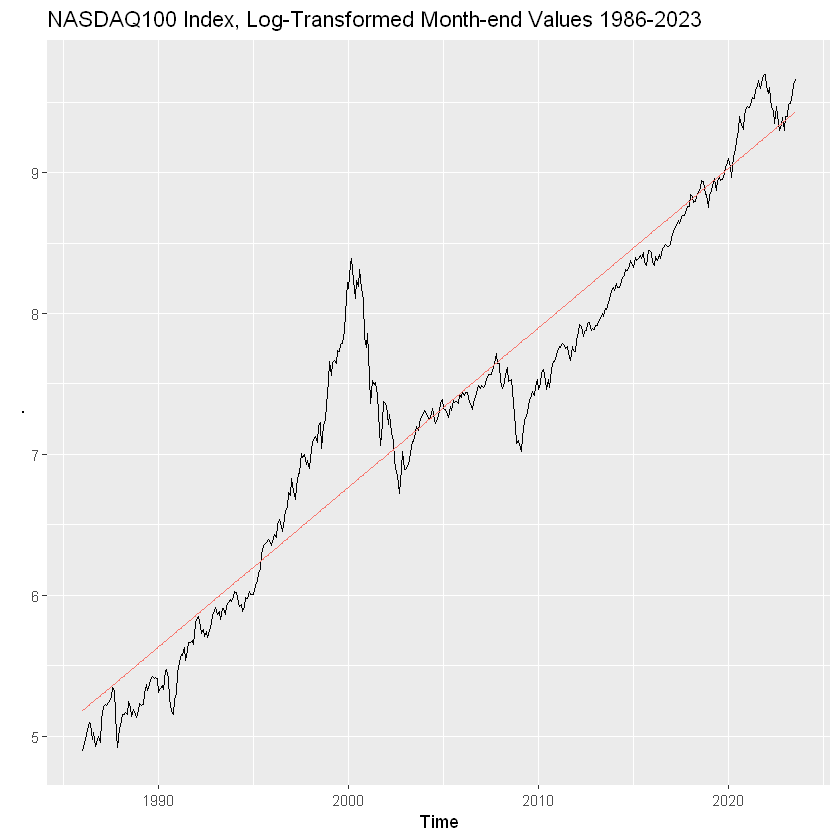

In [11]:
logNasdaq100TrendModel <- tslm(logNasdaq100 ~ trend) %>% 
    predict(logNasdaq100) %>% 
    ts(start=start(logNasdaq100), frequency=frequency(logNasdaq100))

logNasdaq100 %>% autoplot() +
    autolayer(logNasdaq100TrendModel, series='Linear Trend') +
    theme(legend.position="none") +
    ggtitle('NASDAQ100 Index, Log-Transformed Month-end Values 1986-2023')


### Cycles
- Rising or falling at irregular frequencies.
- Could be due to economic or business conditions.
- In economic data, these are general 12-24 months at least.
- Higher frequency data will have shorter duration cyclical behavior. 

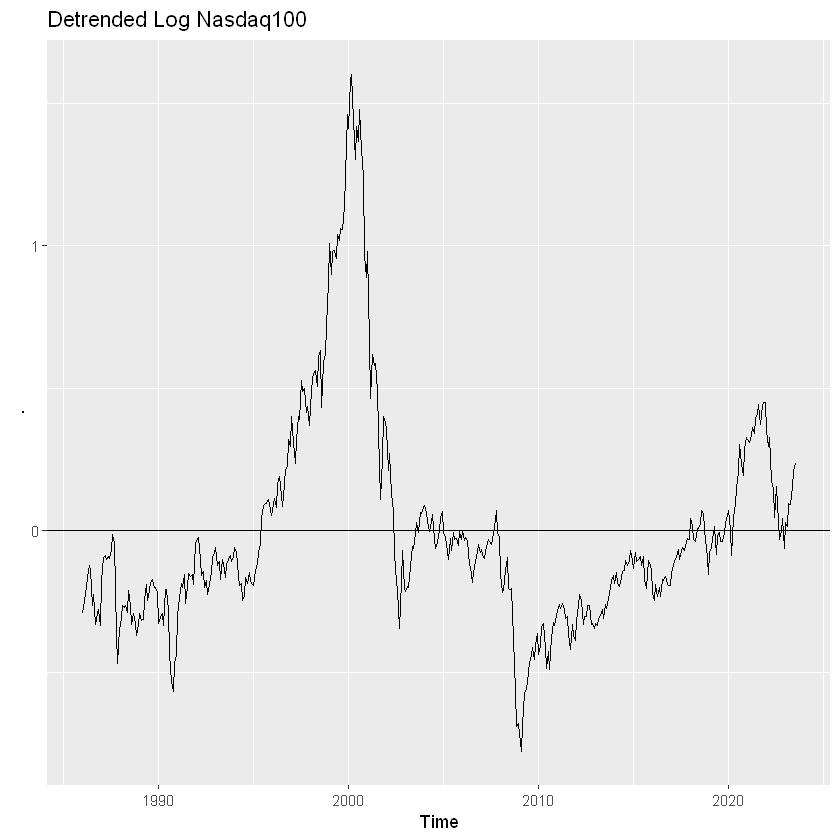

In [12]:
logNasdaq100Detrend <- logNasdaq100 - logNasdaq100TrendModel
detrendPlot <- logNasdaq100Detrend %>% 
    autoplot() +
    ggtitle('Detrended Log Nasdaq100') +
    geom_hline(yintercept=0)

detrendPlot

#### Chart Annotations
Leverage the ability to shade and annotation the chart to provide context.

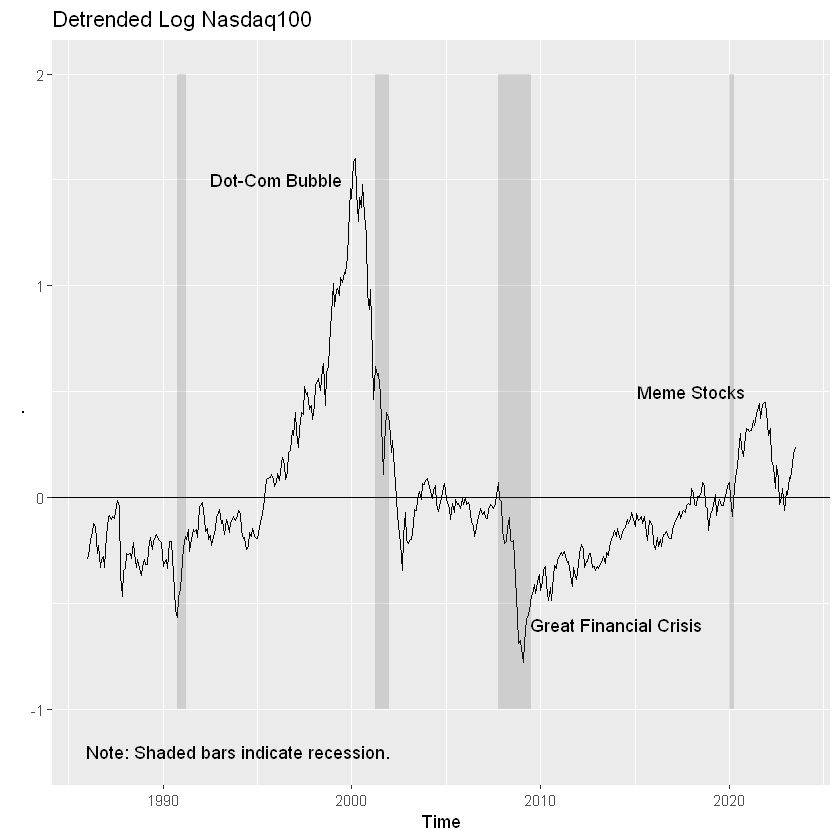

In [13]:
detrendPlot +
    annotate("text", x=1996, y=1.5, label='Dot-Com Bubble') +
    annotate("text", x=2014, y=-.6, label='Great Financial Crisis') +
    annotate("text", x=2018, y=.5, label="Meme Stocks") +
    annotate("rect", xmin=1990.75, xmax=1991.25, ymin=-1, ymax=2, alpha=0.2) +
    annotate("rect", xmin=2001.25, xmax=2002, ymin=-1, ymax=2, alpha=0.2) +
    annotate("rect", xmin=2007.75, xmax=2009.5, ymin=-1, ymax=2, alpha=0.2) +
    annotate("rect", xmin=2020, xmax=2020.25, ymin=-1, ymax=2, alpha=0.2) +
    annotate("text", x=1994, y=-1.2, label='Note: Shaded bars indicate recession.')
    
    

### Investigating Seasonality

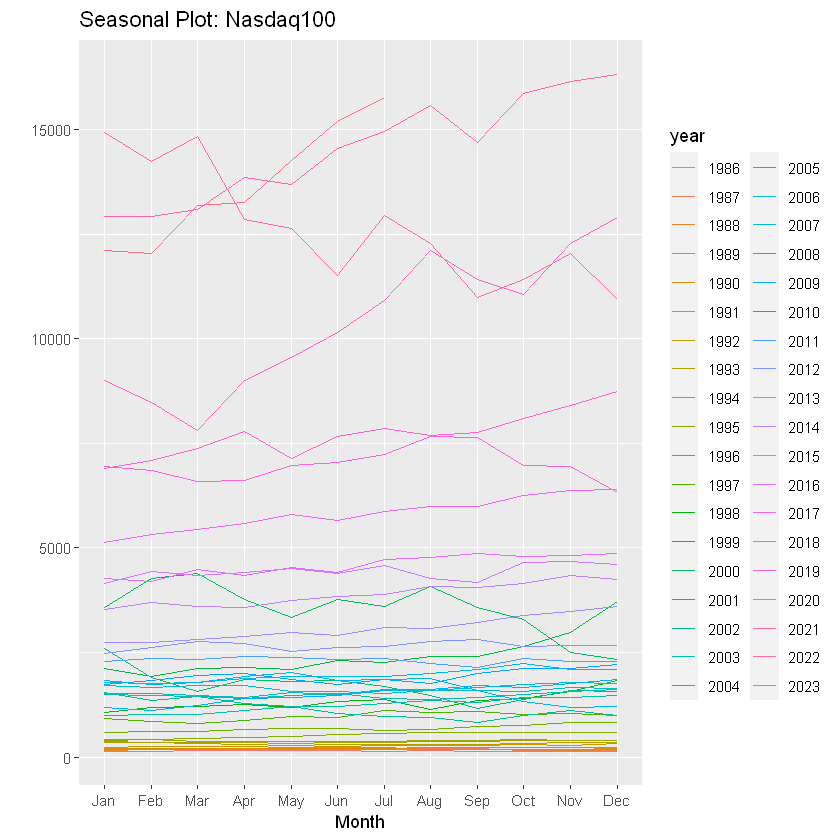

In [14]:
nasdaq100 %>%
    ggseasonplot() +
    ggtitle('Seasonal Plot: Nasdaq100')

- Not going to be too useful on the level time-series in most cases.
- Usually want to look at differenced data, unless the data is stationary around a mean.

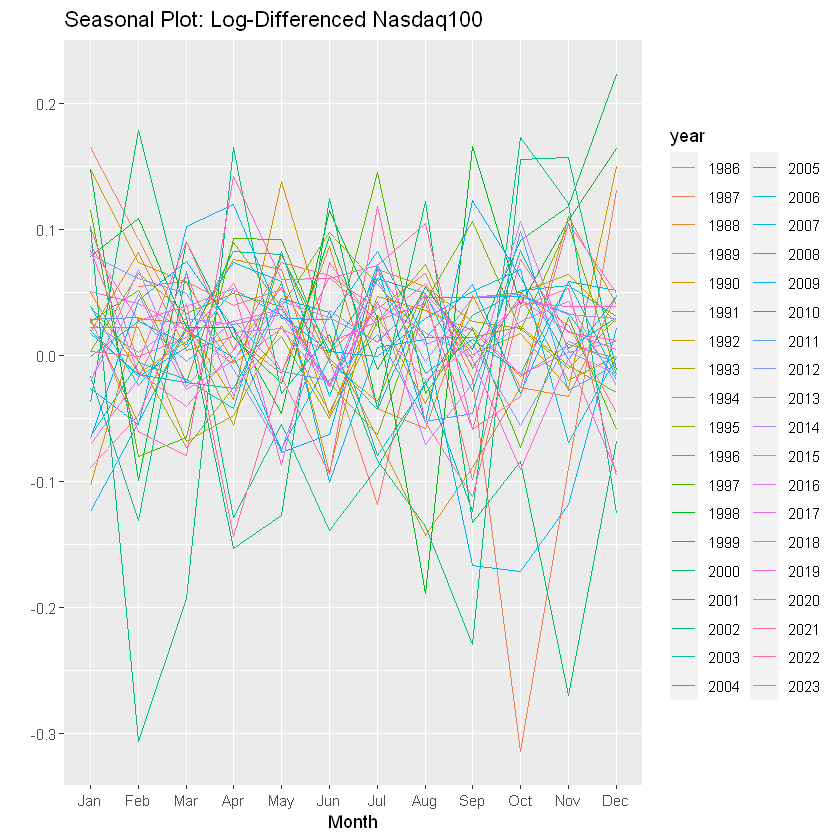

In [15]:
logNasdaq100 %>%
    diff() %>%
    ggseasonplot() +
    ggtitle('Seasonal Plot: Log-Differenced Nasdaq100')

- In this case there doesn't seem like seasonality exists.
- Strong seasonality might appear like the below:

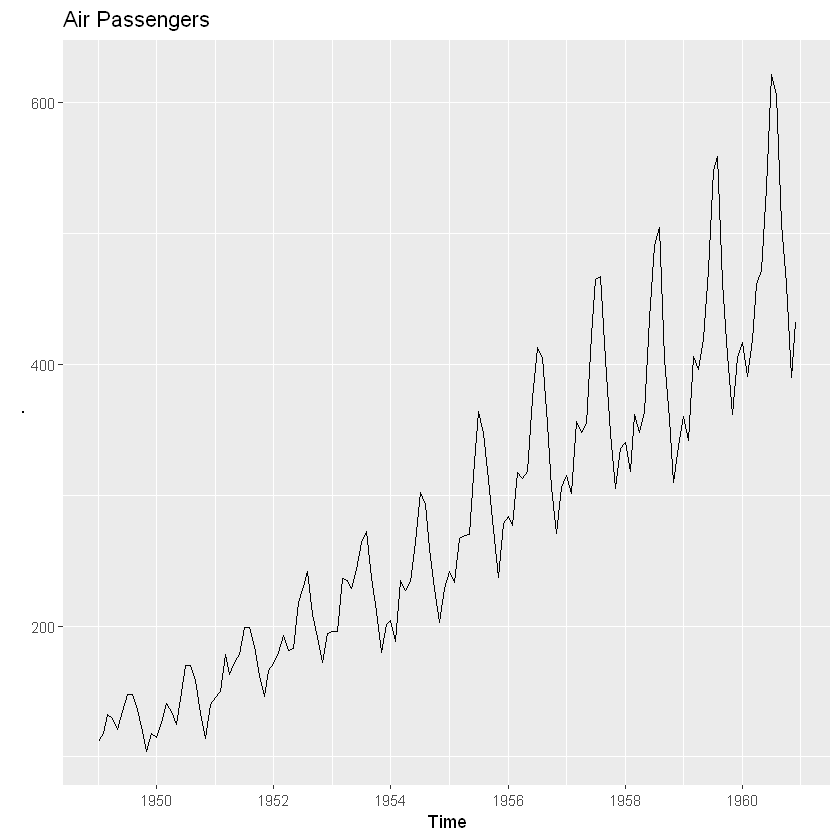

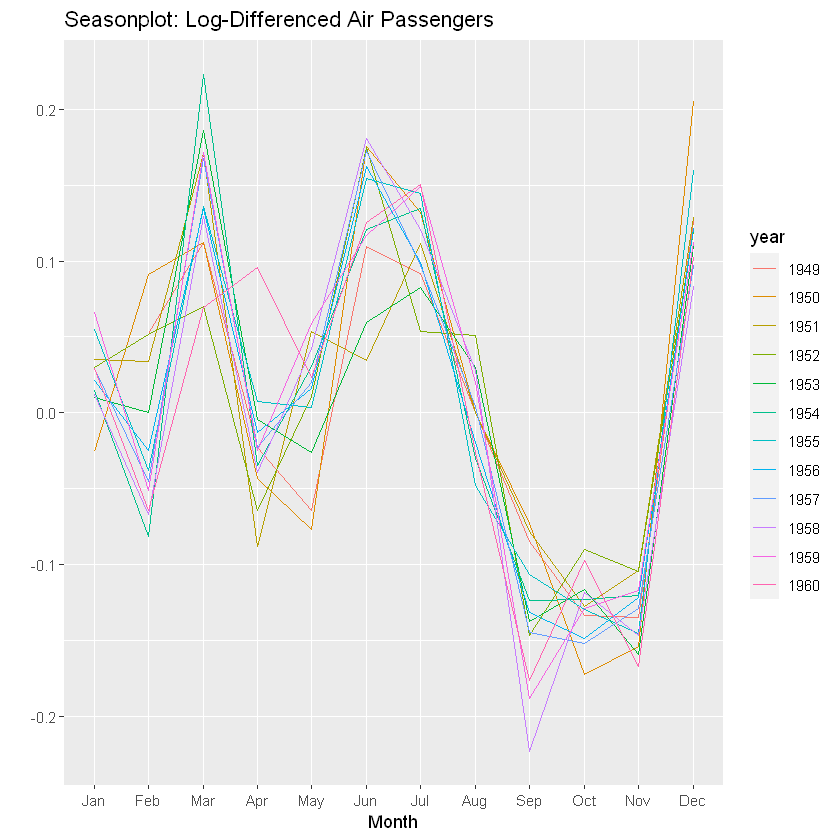

In [16]:
data(AirPassengers)
AirPassengers %>% autoplot() + ggtitle('Air Passengers')
AirPassengers %>% log() %>% diff() %>% ggseasonplot() + ggtitle('Seasonplot: Log-Differenced Air Passengers')

### Subseries Plots - Another Way to View Seasonality
- Create time series for each month of each year, e.g., Jan'71, Jan'72, ...., Feb'71, Feb'72, ...
- Easily tell the level differences in the change month-month

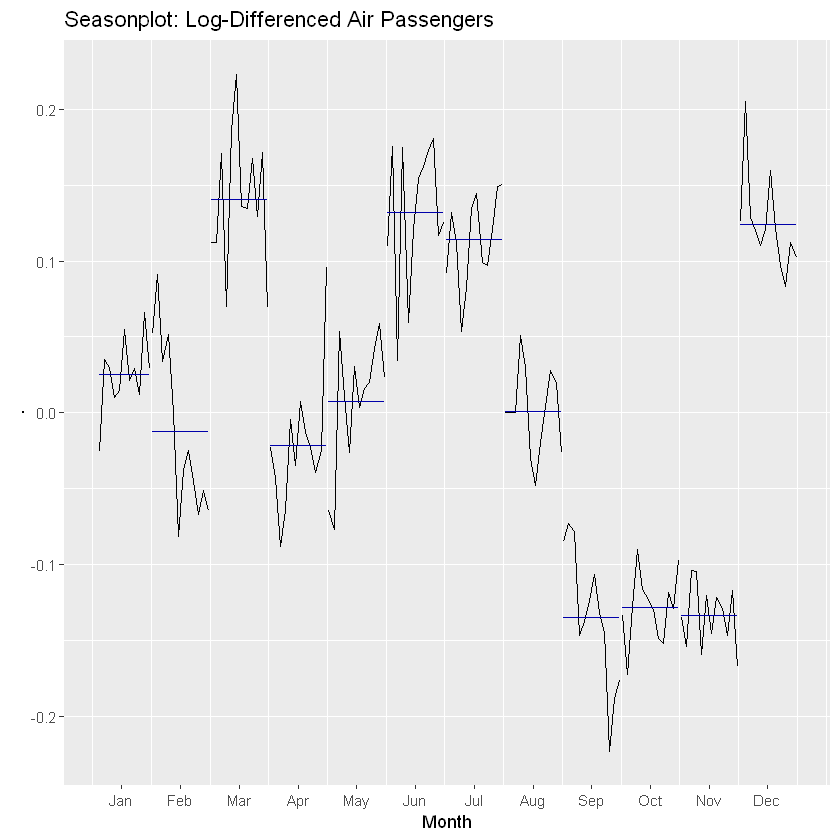

In [17]:
AirPassengers %>% log() %>% diff() %>% ggsubseriesplot() + ggtitle('Seasonplot: Log-Differenced Air Passengers')

### Polar Coordinate for Showing Continuity of Seasonality

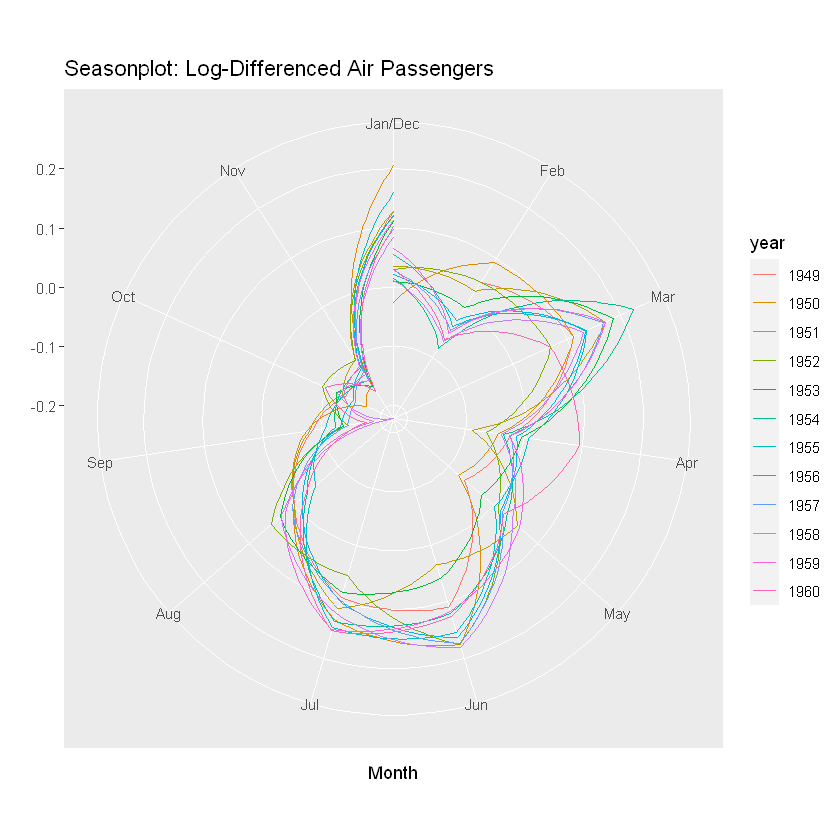

In [18]:
AirPassengers %>% log() %>% diff() %>% ggseasonplot() + ggtitle('Seasonplot: Log-Differenced Air Passengers') + coord_polar()

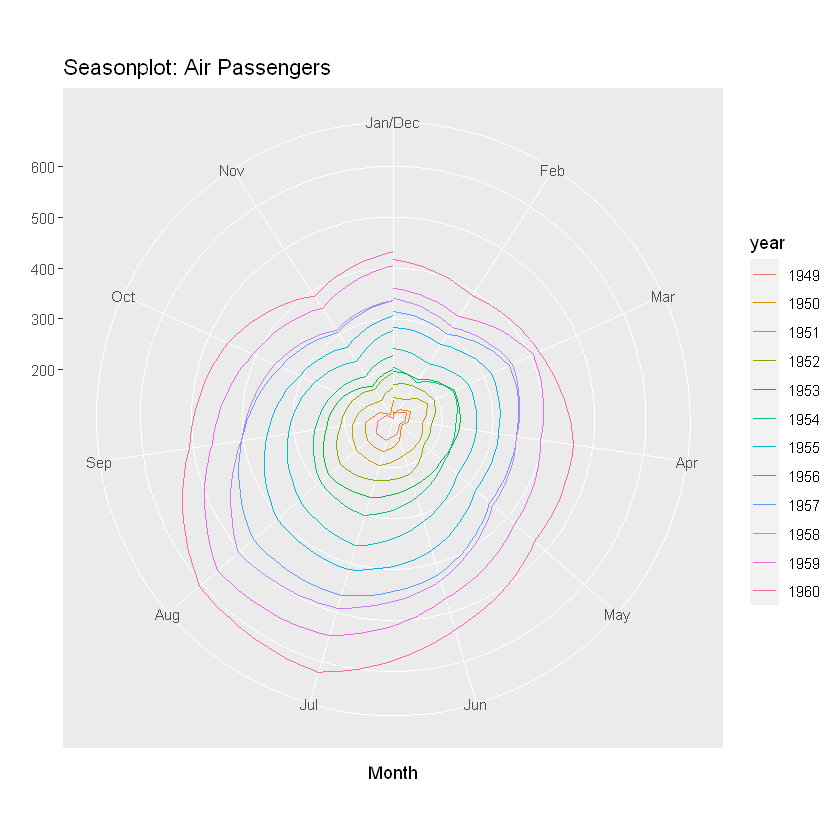

In [19]:
AirPassengers %>% ggseasonplot() + ggtitle('Seasonplot: Air Passengers') + coord_polar()

### Heat Maps

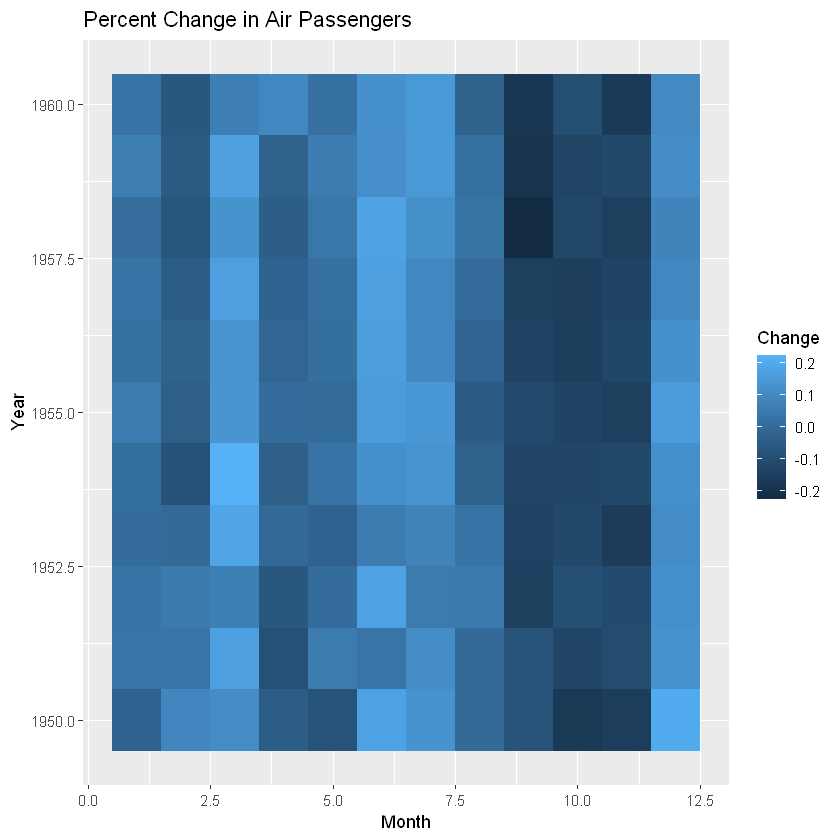

In [20]:
AirPassengers %>% 
as_tsibble() %>%
rename(month = index, passengers = value) %>%
mutate(month_part = lubridate::month(month), year_part = lubridate::year(month), Change=difference(log(passengers))) %>% 
filter_index('1950 Jan' ~ .) %>%
ggplot() +
geom_tile(aes(x=month_part, y=year_part, fill=Change)) +
labs(x='Month',y='Year', title='Percent Change in Air Passengers')

### Multiple Series

In [21]:
consumption <- read.csv('data/PCECC96.csv')
govt <- read.csv('data/gcec1.csv')
investment <- read.csv('data/GPDIC1.csv')
exports <- read.csv('data/expgsc1.csv')
imports <- read.csv('data/impgsc1.csv')

net_exports <- exports %>%
    left_join(imports, by=c('DATE')) %>%
    mutate(Exports = EXPGSC1 - IMPGSC1) %>%
    select(DATE, Exports)

consumption <- consumption %>% rename(Consumption = PCECC96)
govt <- govt %>% rename(Government = GCEC1)
investment <- investment %>% rename(investment = GPDIC1)

gdp <- consumption %>% left_join(govt, by='DATE') %>%
left_join(investment, by='DATE') %>%
left_join(net_exports, by='DATE') %>%
mutate(DATE = as.Date(DATE))

gdp <- gdp %>% pivot_longer(!DATE, values_to = 'Dollars', names_to = 'Component') %>% as_tsibble(key='Component', index='DATE')


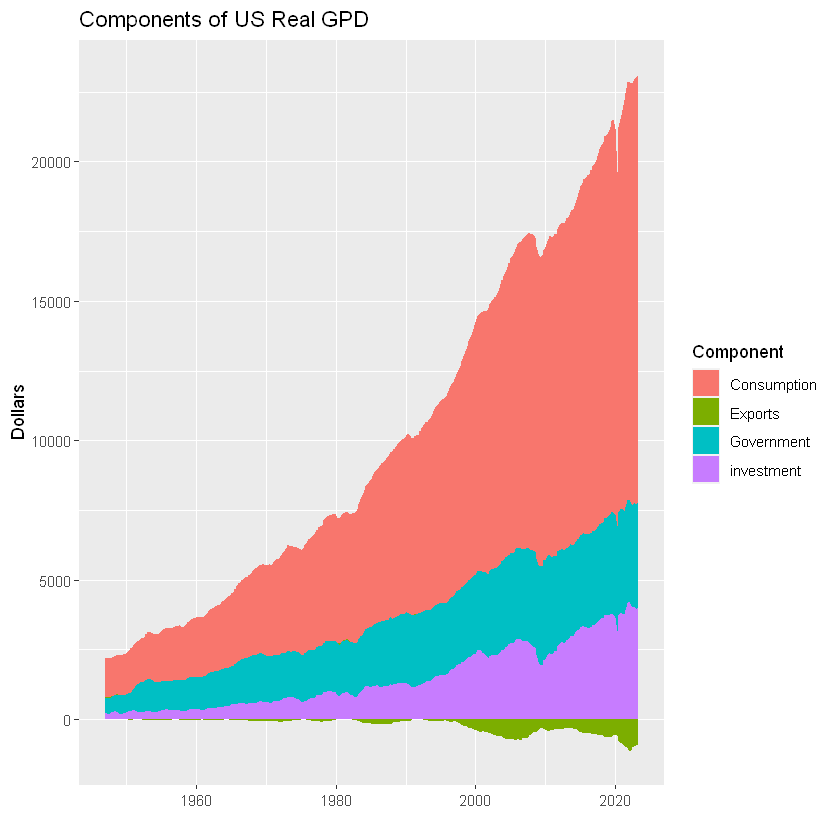

In [22]:
gdp %>% 
    ggplot(aes(x=DATE, y=Dollars, fill=Component)) + 
    geom_area() +
    ggtitle('Components of US Real GPD') +
    xlab('')

In [23]:
totalGDP <- gdp %>% index_by(DATE) %>% summarise(Total = sum(Dollars))

gdp <- gdp %>% left_join(totalGDP, by=c('DATE')) %>% mutate(Percent = Dollars/Total)
gdp %>% head()

DATE,Component,Dollars,Total,Percent
<date>,<chr>,<dbl>,<dbl>,<dbl>
1947-01-01,Consumption,1351.397,2179.060,0.6201743
1947-04-01,Consumption,1373.880,2181.493,0.6297889
1947-07-01,Consumption,1378.358,2181.252,0.6319114
1947-10-01,Consumption,1378.796,2204.040,0.6255767
1948-01-01,Consumption,1385.667,2234.085,0.6202392
1948-04-01,Consumption,1401.789,2277.497,0.6154954


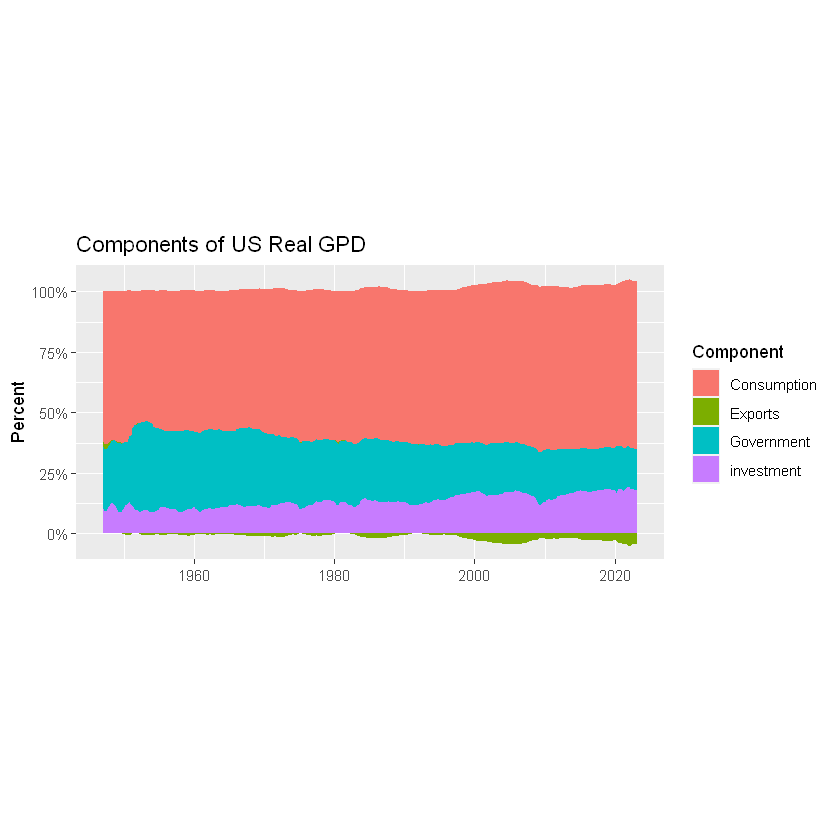

In [24]:
gdp %>% 
    ggplot(aes(x=DATE, y=Percent, fill=Component)) + 
    geom_area() +
    ggtitle('Components of US Real GPD') +
    scale_y_continuous(labels=scales::percent)+
    xlab('') +
    theme(aspect.ratio = 0.5)

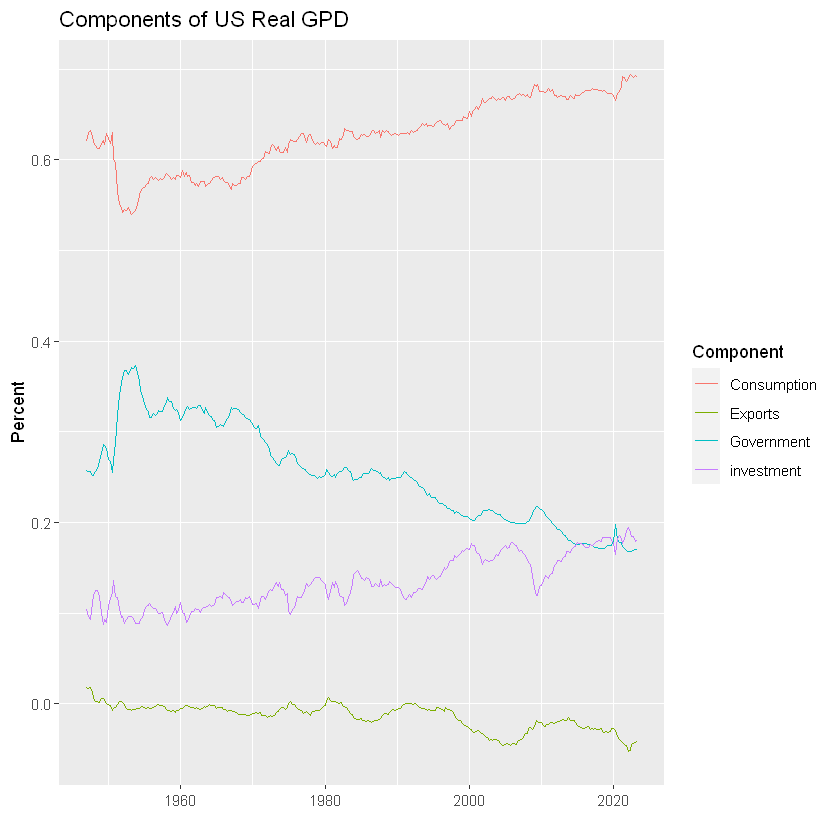

In [25]:
gdp %>% 
    ggplot(aes(x=DATE, y=Percent, color=Component)) + 
    geom_line() +
    ggtitle('Components of US Real GPD') +
    xlab('')

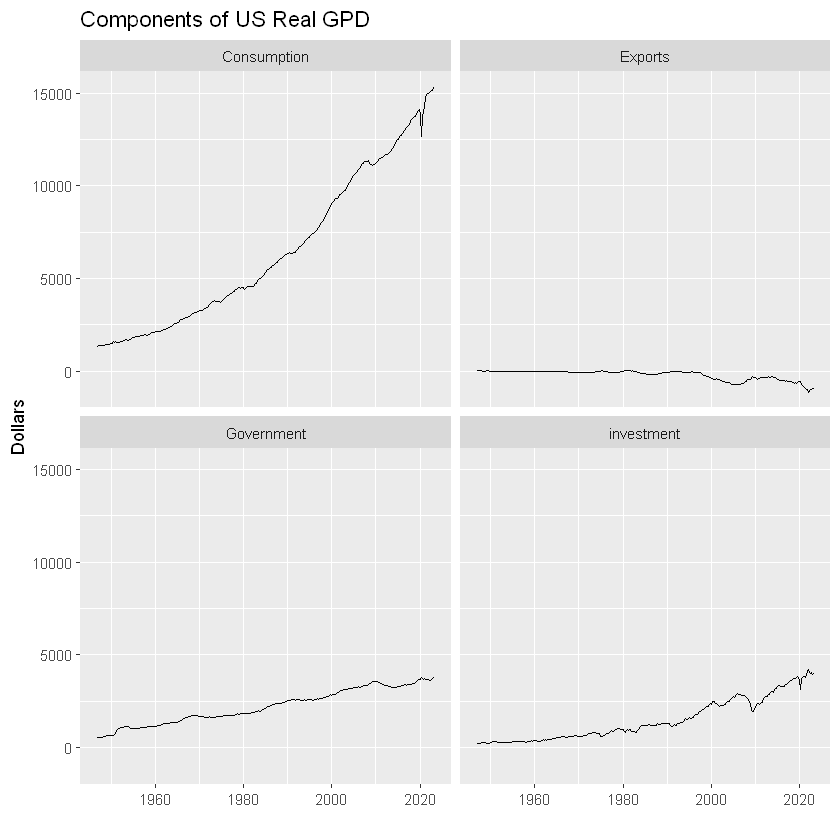

In [26]:
gdp %>% 
    ggplot(aes(x=DATE, y=Dollars)) + 
    geom_line() +
    facet_wrap(~Component) +
    ggtitle('Components of US Real GPD') +
    xlab('')

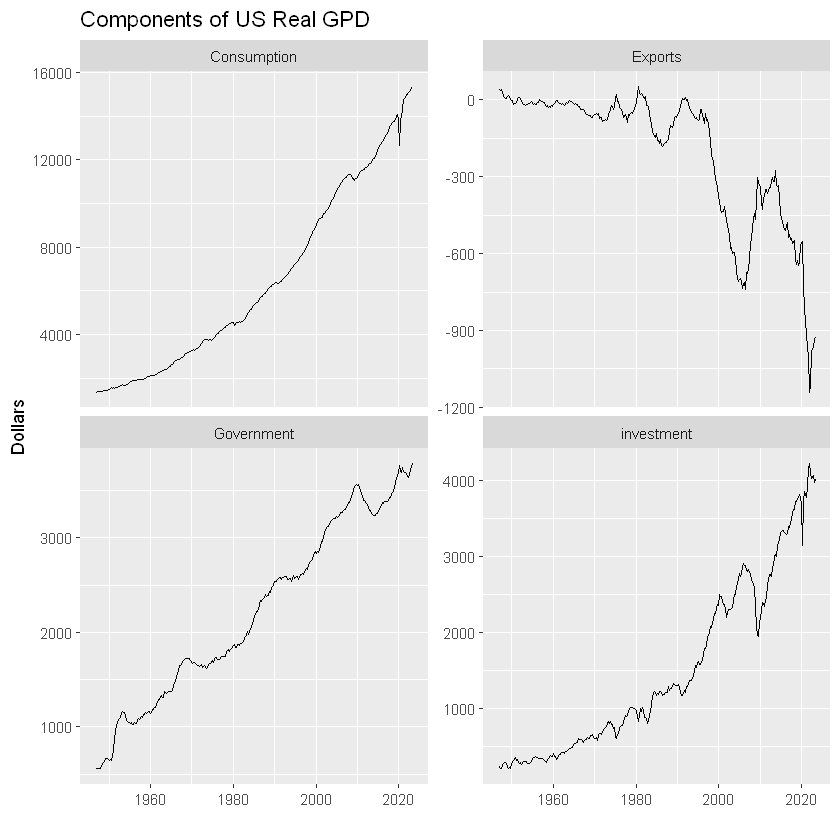

In [27]:
gdp %>% 
    ggplot(aes(x=DATE, y=Dollars)) + 
    geom_line() +
    facet_wrap(~Component, scales = 'free_y') +
    ggtitle('Components of US Real GPD') +
    xlab('')

### Lag Plots

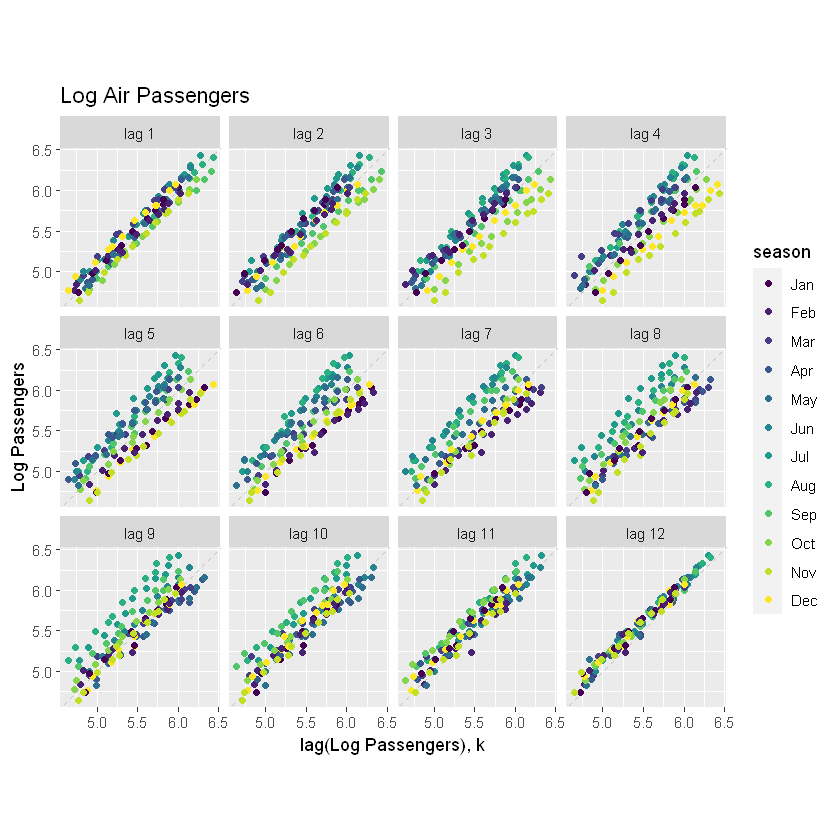

In [28]:
AirPassengers %>% log() %>% as_tsibble() %>% gg_lag(value, geom='point', lags=1:12) + ggtitle('Log Air Passengers') + xlab('lag(Log Passengers), k') + ylab('Log Passengers')

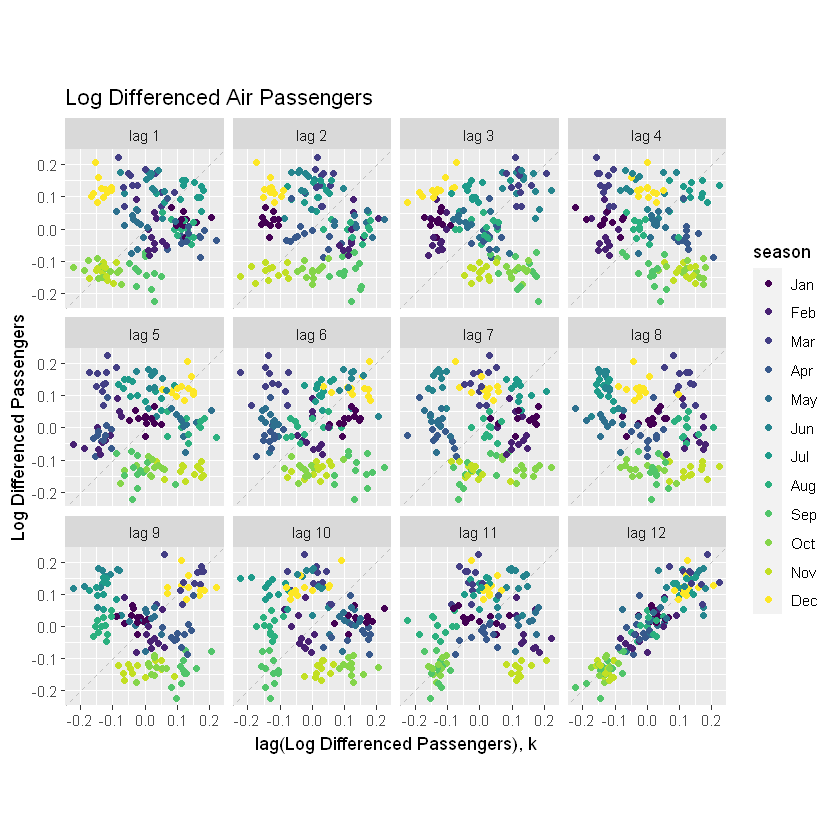

In [29]:
AirPassengers %>% log() %>% diff() %>% as_tsibble() %>% gg_lag(value, geom='point', lags=1:12) + ggtitle('Log Differenced Air Passengers') + xlab('lag(Log Differenced Passengers), k') + ylab('Log Differenced Passengers')

### Autocorrelation

In [30]:
AirPassengers %>% log() %>% as_tsibble() %>% ACF(value, lag_max=10) 

lag,acf
<cf_lag>,<dbl>
1M,0.9537034
2M,0.8989159
3M,0.8508025
4M,0.8084252
5M,0.7788994
6M,0.7564422
7M,0.7376017
8M,0.7271313
9M,0.7336487


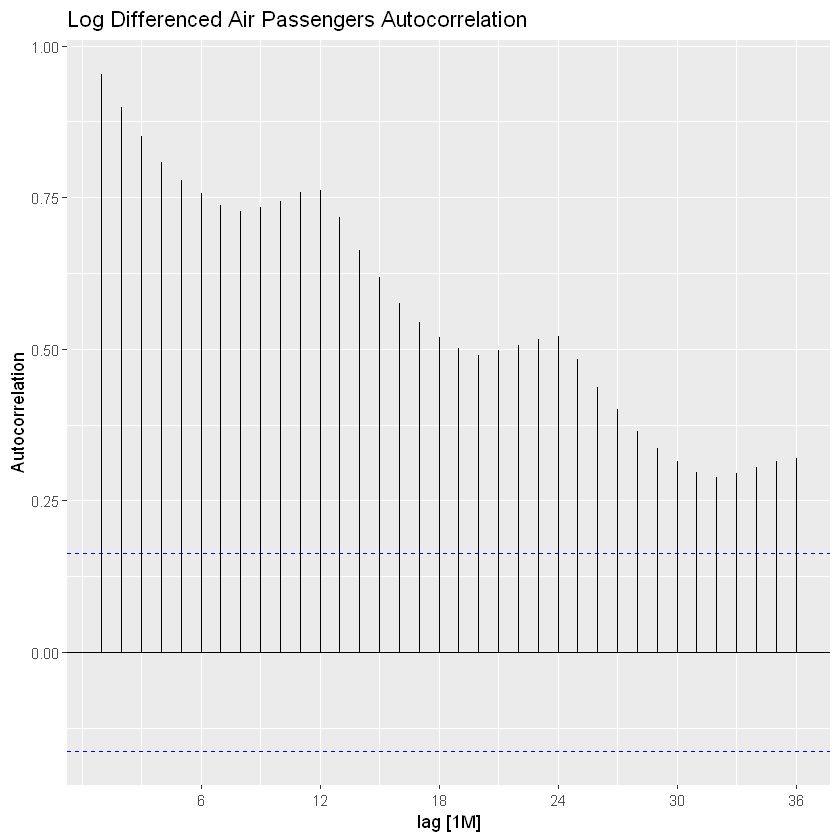

In [31]:
AirPassengers %>% log() %>% as_tsibble() %>% ACF(value, lag_max=36) %>% autoplot() + labs(title='Log Differenced Air Passengers Autocorrelation') + ylab('Autocorrelation')

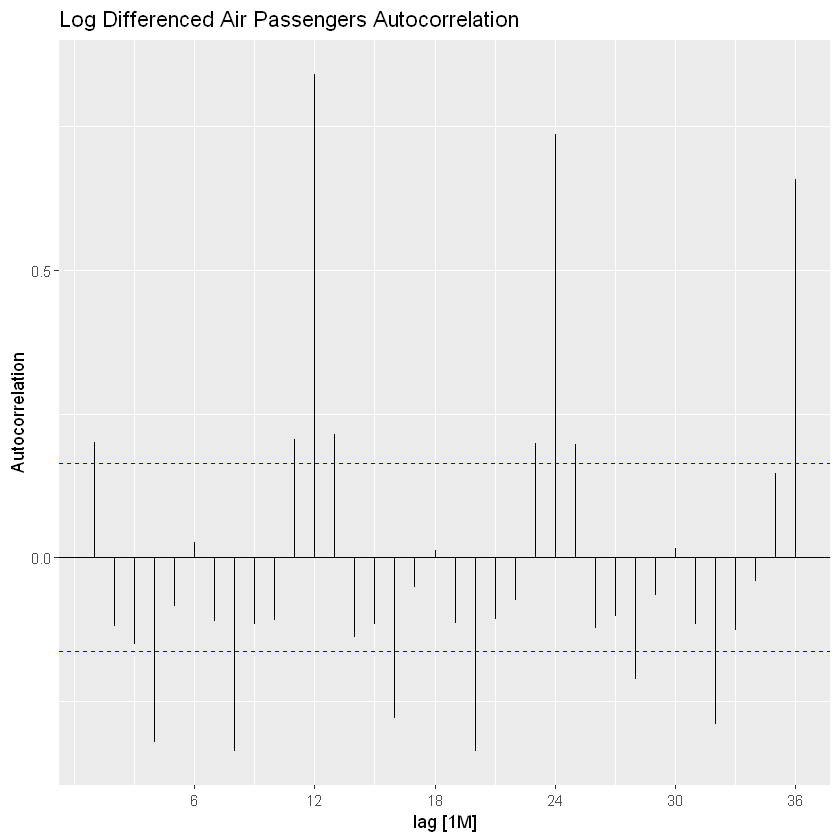

In [32]:
AirPassengers %>% log() %>% diff() %>% as_tsibble() %>% ACF(value, lag_max=36) %>% autoplot() + labs(title='Log Differenced Air Passengers Autocorrelation') + ylab('Autocorrelation')

### Rolling Averages

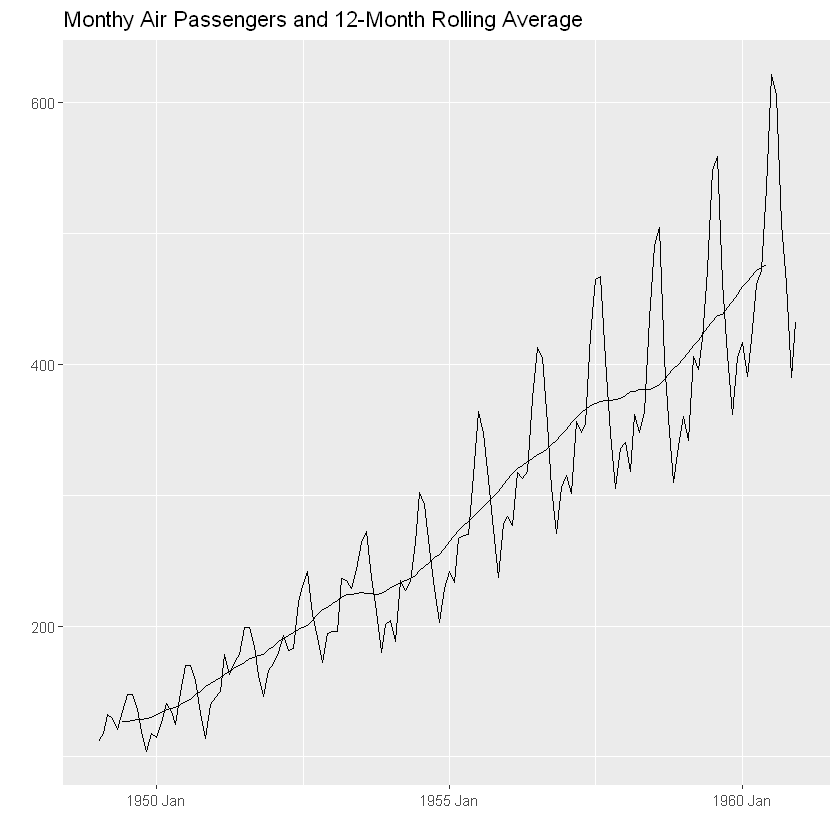

In [33]:
rollingAir <- zoo::rollmean(AirPassengers, 12) %>% as_tsibble()

AirPassengers %>% as_tsibble() %>% autoplot(value) + autolayer(rollingAir, value) +
labs(title = 'Monthy Air Passengers and 12-Month Rolling Average', x='', y='')